# Experiments

In [1]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.callbacks import TensorBoard

from sklearn import preprocessing
from sklearn import metrics

import common

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


## Data Processing

In [16]:
# load all csv files of North-point site. Concatenate them..
df = common.load_df("../data/insead", "*.csv")
print(common.load_df.cache_info())

# preprocess.
df = common.remove_negatives(df)
df = common.identify_ct_shutdown(df)
df = common.replace_missing(df)

# Get the first derivative. The idea is that this makes the time series stationary.
df = common.get_normalized_df(df, scale=(0.1, 1))

CacheInfo(hits=1, misses=1, maxsize=None, currsize=1)


In [17]:
# remove sudden peaks
thresh = df.rolling(50, min_periods=1).median()
df[df > thresh] = thresh

## Take a sample

In [36]:
# manually select training and validaiton data.
batch_size = 200
train_df = df["2017-01-01":"2017-02"]
validation_df = df["2017-03-01":"2017-03-10"]

# The recipe.
features = ["loadsys", "drybulb", "rh"]
target = ["cwshdr"]
lookback = 8

# Prepare features and target vectors
train_x, train_y = common.prepare_features(train_df, features, target, N=lookback)
validation_x, validation_y = common.prepare_features(validation_df, features, target, N=lookback)
print(train_x.shape, train_y.shape)

# Equalize length
train_x = common.equalize_length(train_x, batch_size)
train_y = common.equalize_length(train_y, batch_size)
validation_x = common.equalize_length(validation_x, batch_size)
validation_y = common.equalize_length(validation_y, batch_size)

# Reshape to Keras requirements
train_x = common.Reshape.x(train_x)
train_y = common.Reshape.y(train_y)
validation_x = common.Reshape.x(validation_x)
validation_y = common.Reshape.y(validation_y)
print(train_x.shape, train_y.shape)

(84751, 8, 3) (84751, 1)
(84600, 1, 24) (84600, 1, 1)


## Prepare model

In [37]:
model = Sequential([
    LSTM(24 * 3, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), stateful=True, return_sequences=True),
    Dense(1)
])

model.compile(
    loss=mean_squared_error,
    optimizer="adam",
    metrics=["accuracy", mean_absolute_percentage_error]
)

## Train model

In [38]:
hist_list = []

for epoch in range(100):
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=batch_size,
        verbose=0,
        shuffle=False,
        epochs=1,
        validation_data=(validation_x, validation_y),
        callbacks=[TensorBoard(log_dir="../output/keras7")])
    model.reset_states()
    hist_list.append(history)
    
    if epoch % 20 == 0:
        print("At epoch ", epoch)

At epoch  0
At epoch  20


KeyboardInterrupt: 

## Metrics

In [39]:
# Test the validation sample...
predicted_y = model.predict(validation_x, batch_size=batch_size) # predict
predicted_y = common.Reshape.inv_y(predicted_y) # reshape to normal (Numpy's origin shape)
validation_y = common.Reshape.inv_y(validation_y)

# Inverse scale a particular dimension of the dataset.
idx = list(df.columns).index(target[0])
inv_validation_y = common.inverse_scale(df.scaler, validation_y, idx)
inv_predicted_y = common.inverse_scale(df.scaler, predicted_y, idx)

print("MSE: ", metrics.mean_squared_error(validation_y, predicted_y))
print("MAPE: ", common.mean_absolute_percent_error(validation_y, predicted_y))

MSE:  0.000444368383286
MAPE:  1.91796514495


## Forecast

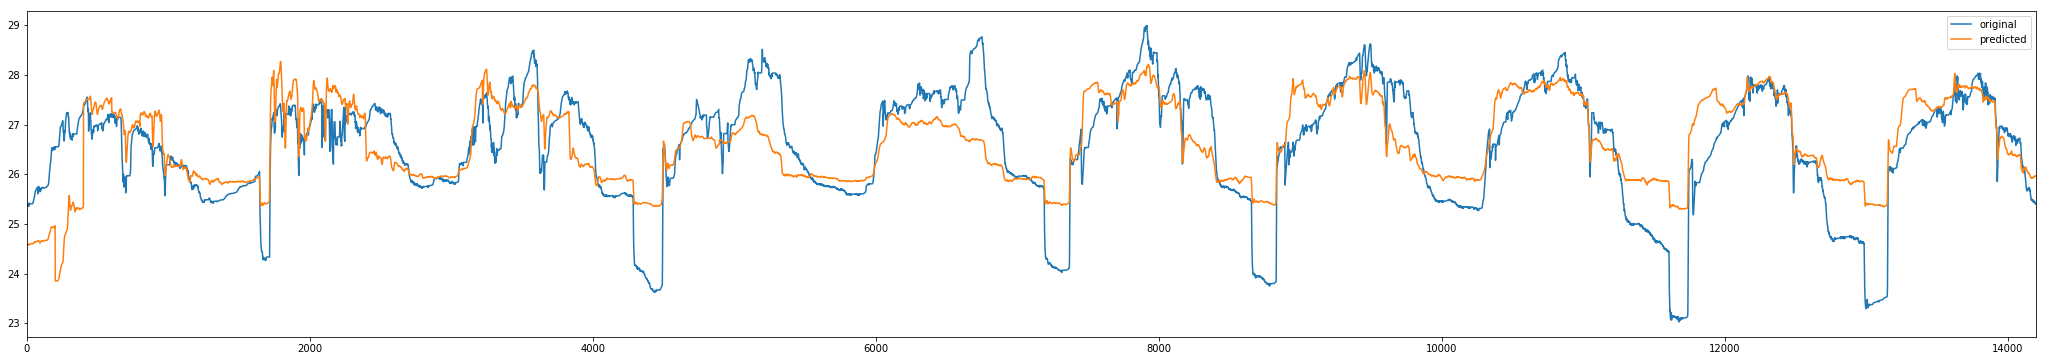

In [41]:
plot_df = pd.DataFrame({"original": inv_validation_y, "predicted": inv_predicted_y})
ax = plot_df.plot(figsize=(36,6))

## Observations & Conclusions

Tensorflow Log Dir: Keras3

1. The validation MAPE shows strong signs of overfitting.
2. The zeros are messing up again??